In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from state_config import state_conversion

sns.set()
pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000

### Analysis of The COVID Tracking Project Numbers
- Twitter: @COVID19Tracking
- Interest primarily in how hospitalizations have changed over time

In [2]:
data = pd.read_csv('../data/tctp.csv')

# Reformat
date_columns = ['date', 'lastUpdateEt', 'dateChecked']
for column in date_columns:
    if column == 'date':
        data[column] = pd.to_datetime(data[column], format='%Y%m%d')
    else:
        data[column] = pd.to_datetime(data[column])
        
# Keep only states 
data = data[data['state'].isin(state_conversion.keys())]

# Keep only data points after 
# 3/11/20 (incomplete data prior to this date)
# Start with first of April due to incomplete data across states
# for hospitalization
data = data[data['date'] > '2020-03-31']

# Order data by date
data.sort_values('date', ascending=True, inplace=True)

# Look at only data of interest
columns = ['state', 'date', 'hospitalizedIncrease', 'hospitalizedCurrently', 'hospitalizedCumulative']
data = data.loc[:, columns]

print(data.shape)
data.head()

(2700, 5)


,state,date,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative
3023,WY,2020-04-01,1.0,NaN,18.0
2992,MI,2020-04-01,0.0,NaN,NaN
2991,ME,2020-04-01,6.0,NaN,63.0
2990,MD,2020-04-01,93.0,NaN,522.0
2989,MA,2020-04-01,120.0,NaN,682.0


Notes:
- Hospitalized currently should be the primary metric of interest. Should want to know if the number of hospitalizations has bbeen increasing. For cases where hospitalized currently is not available, cumulative hospitalizations should be used. Should split these two groups.
- Hospitalized Currently: AK 4-18-20, AR 3-22-20, AZ 4-13-20, CA 3-27-20, CO 3-22-20, CT 03-22-20, DE 03-25-20,
- Hospitalized Cumulative: AL 4-04-20,
- **Nebraska does not provide data on hospitalizations**

In [3]:
hosp_curr_states = [
    'AK', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 
    'IA', 'IL', 'IN', 'KY', 'LA', 'MA', 'MD', 'ME', 
    'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND',
    'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
    'OR', 'PA', 'RI', 'SD', 'TX', 'UT', 'VA',
    'VT', 'WA', 'WI', 'WV',
#     'WY'
]
hosp_cum_states = ['AL', 'FL', 'GA', 'HI', 'ID', 'KS', 'NE', 'SC', 'TN']

In [4]:
# Get states with current hospital counts
temp = (
    data[data['state'].isin(hosp_curr_states)]
    .sort_values(['state', 'date'], ascending=True)
    .fillna(method='bfill')   
)
temp.tail()

,state,date,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative
278,WV,2020-05-20,0.0,58.0,NaN
222,WV,2020-05-21,0.0,46.0,NaN
166,WV,2020-05-22,0.0,47.0,NaN
110,WV,2020-05-23,0.0,39.0,NaN
54,WV,2020-05-24,0.0,23.0,NaN


In [5]:
# Calculate rolling average
temp_dates = temp['date'].values
grouped_rolling = (
    temp.groupby('state')['hospitalizedCurrently']
    .rolling(7, axis=0).mean()
    .reset_index()
    .rename(columns={'hospitalizedCurrently': 'rolling_mean'})
    .drop(columns=['level_1'])
)
grouped_rolling['date'] = temp_dates
grouped_rolling.head()

,state,rolling_mean,date
0,AK,NaN,2020-04-01
1,AK,NaN,2020-04-02
2,AK,NaN,2020-04-03
3,AK,NaN,2020-04-04
4,AK,NaN,2020-04-05


In [6]:
# Combined
temp = temp.merge(
    grouped_rolling,
    on=['state','date']
)
temp.head()

# Get all states and dates
states = temp['state'].unique()
dates = temp['date'].unique()

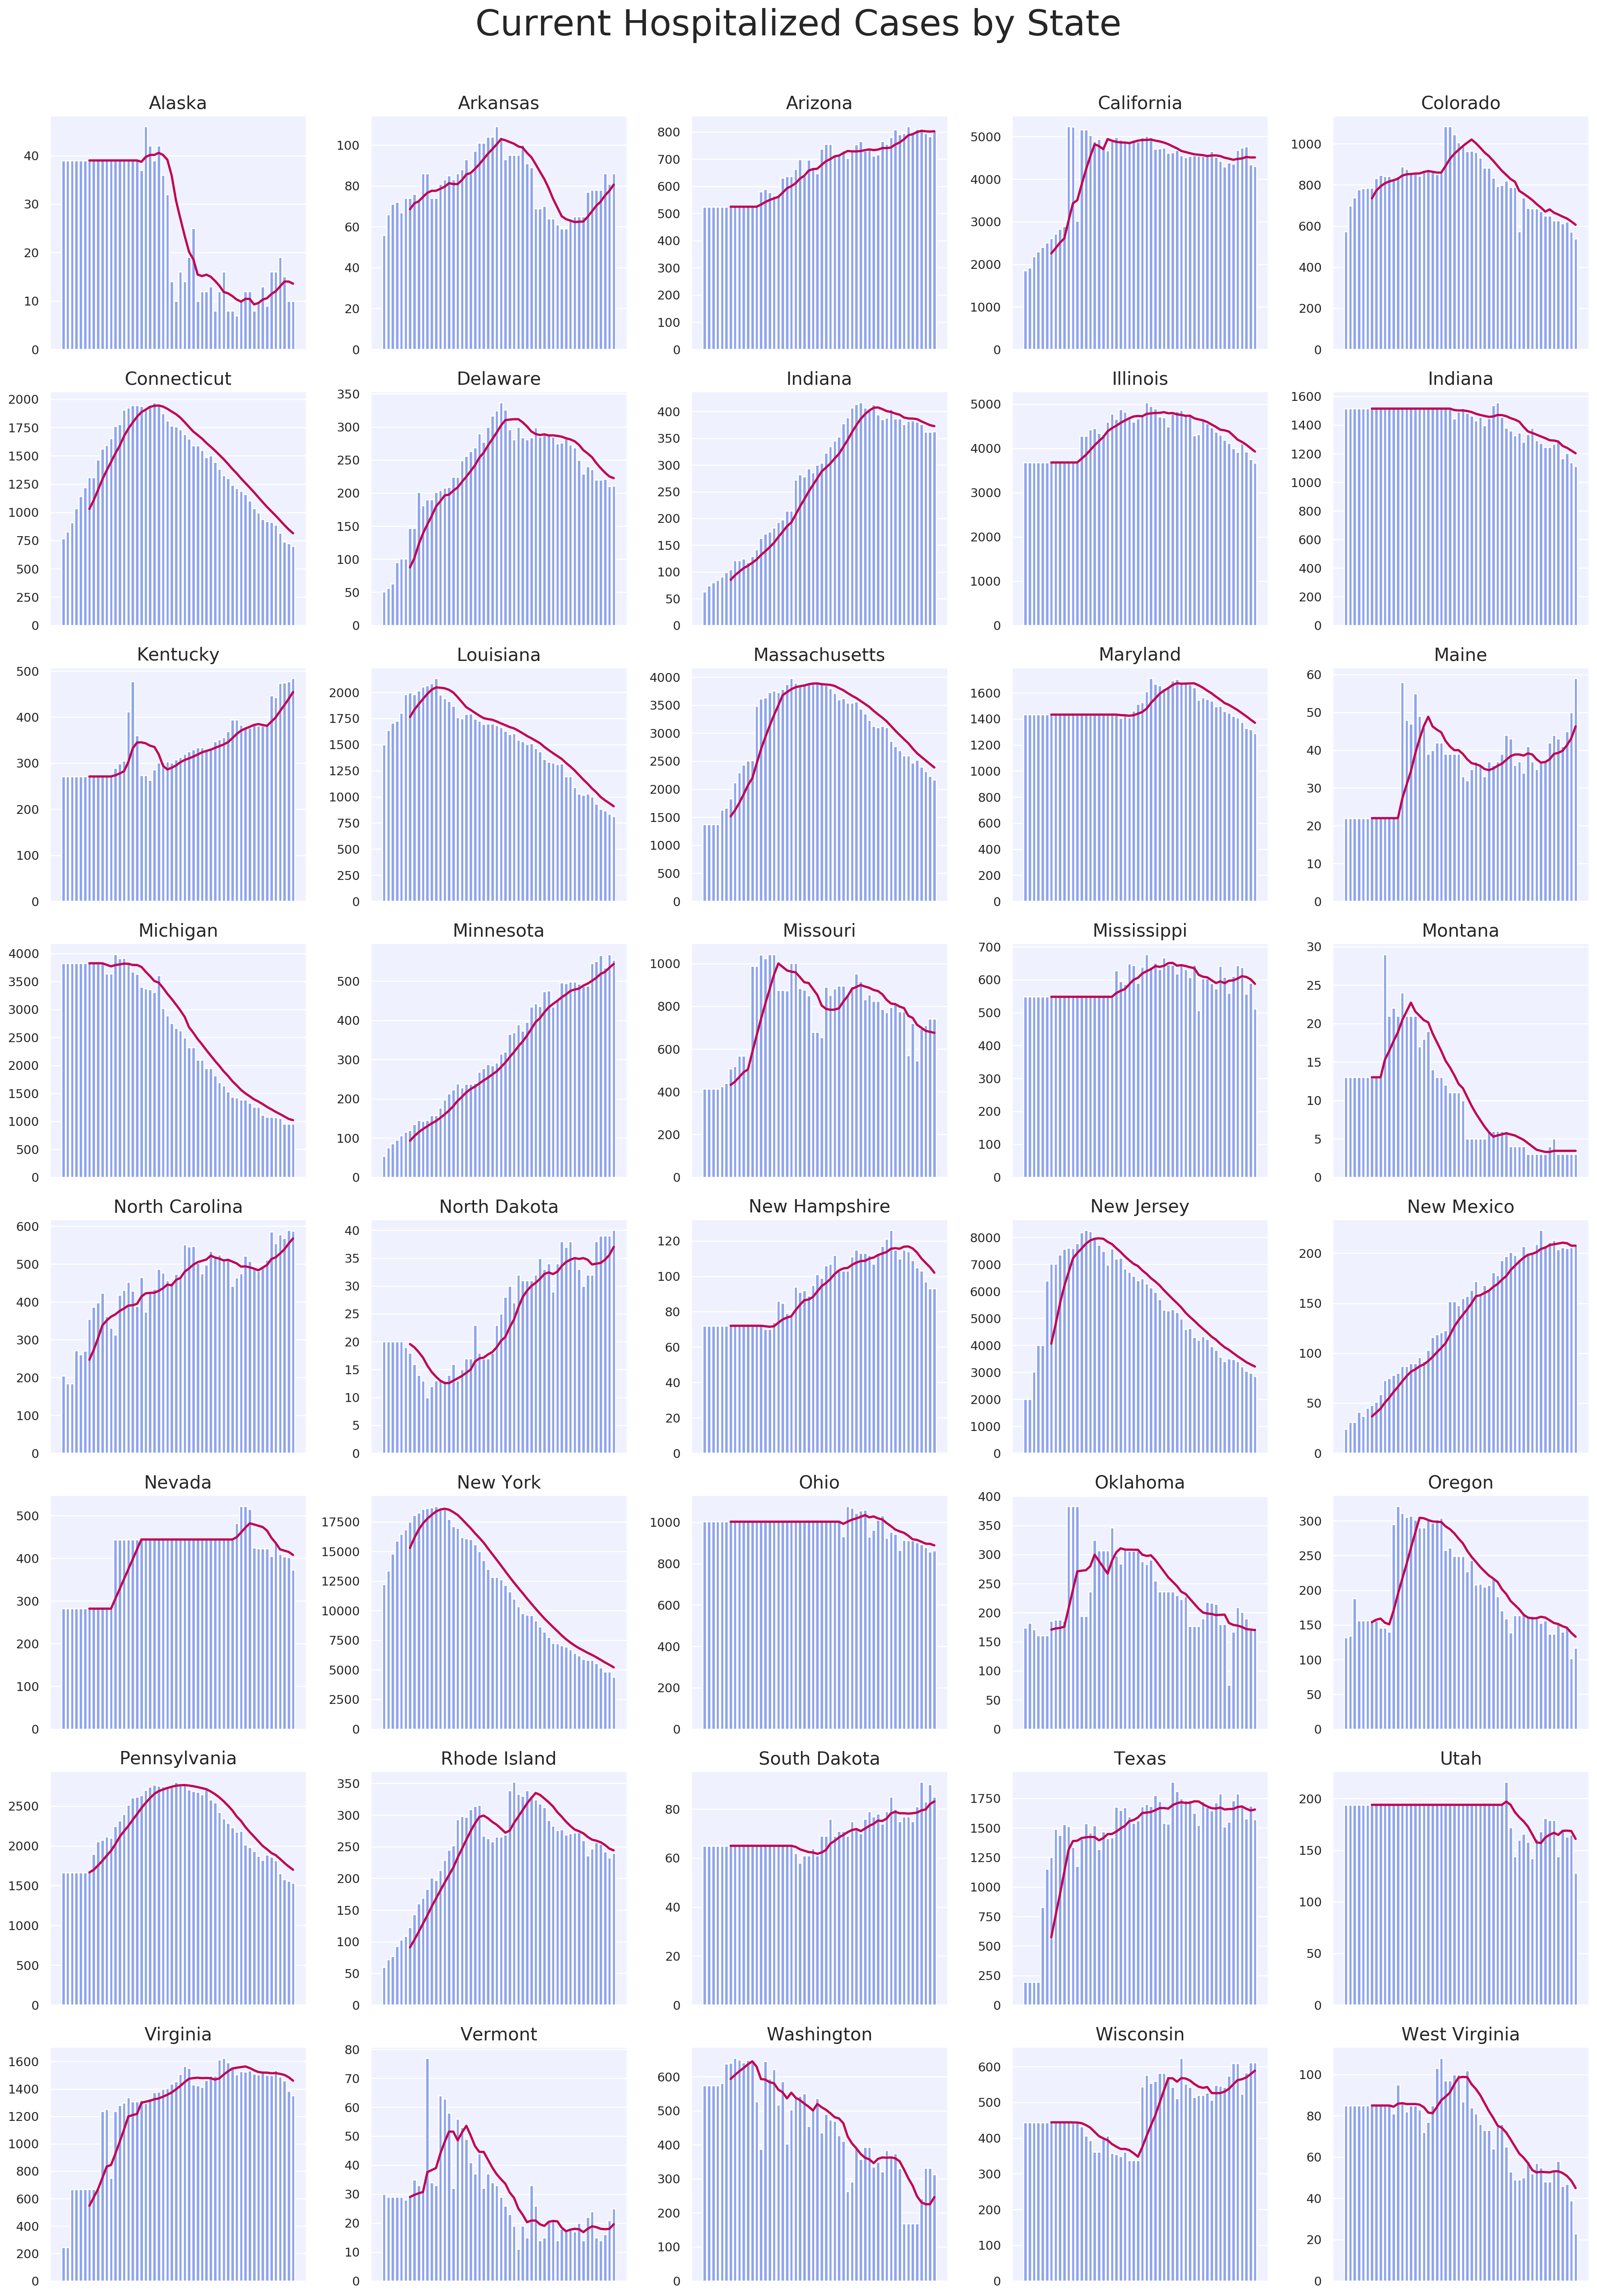

In [7]:
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'

def counts_chart(df, states, dates):
    '''Plot distribution of case counts and the rolling average'''

    fig, axes = plt.subplots(nrows=8, ncols=5, figsize=(20,30), dpi=200)
    fig.suptitle('Current Hospitalized Cases by State', fontsize=32)

    for index, ax in enumerate(axes.flatten()):

        # Isolate state
        state = states[index]
        state_name = state_conversion[state]
        state_df = df[df['state'] == state]

        # Plot parameters
        ax.set_facecolor('#EFF2FE')
        ax.tick_params(labelbottom=False)
        ax.xaxis.grid(False)
        ax.set_title(state_name, fontsize=16)

        # Plot: Distribution of counts per day
        ax.bar(dates, state_df['hospitalizedCurrently'], color='#90A5ED', alpha=1.0, width=0.8)

        # Plot: Rolling Average
        ax.plot(dates, state_df['rolling_mean'], c='#C20051', alpha=1.0, linewidth=2.0)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('../images/hospitalized_cases.png')
    plt.show()
    
counts_chart(temp, states, dates)

#### Cumulative Hospital Counts

In [8]:
# Get states with cummulative hospital counts
temp = (
    data[data['state'].isin(hosp_cum_states)]
    .sort_values(['state', 'date'], ascending=True)
    .fillna(method='bfill')   
)
temp.head()

,state,date,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative
2969,AL,2020-04-01,0.0,472.0,212.0
2913,AL,2020-04-02,0.0,472.0,212.0
2857,AL,2020-04-03,0.0,472.0,212.0
2801,AL,2020-04-04,212.0,472.0,212.0
2745,AL,2020-04-05,19.0,472.0,231.0


In [9]:
# Calculate rolling average
temp_dates = temp['date'].values
grouped_rolling = (
    temp.groupby('state')['hospitalizedCumulative']
    .rolling(7, axis=0).mean()
    .reset_index()
    .rename(columns={'hospitalizedCumulative': 'rolling_mean'})
    .drop(columns=['level_1'])
)
grouped_rolling['date'] = temp_dates
grouped_rolling.head()

,state,rolling_mean,date
0,AL,NaN,2020-04-01
1,AL,NaN,2020-04-02
2,AL,NaN,2020-04-03
3,AL,NaN,2020-04-04
4,AL,NaN,2020-04-05


In [10]:
# Combined
temp = temp.merge(
    grouped_rolling,
    on=['state','date']
)
temp.head()

# Get all states and dates
states = temp['state'].unique()
dates = temp['date'].unique()

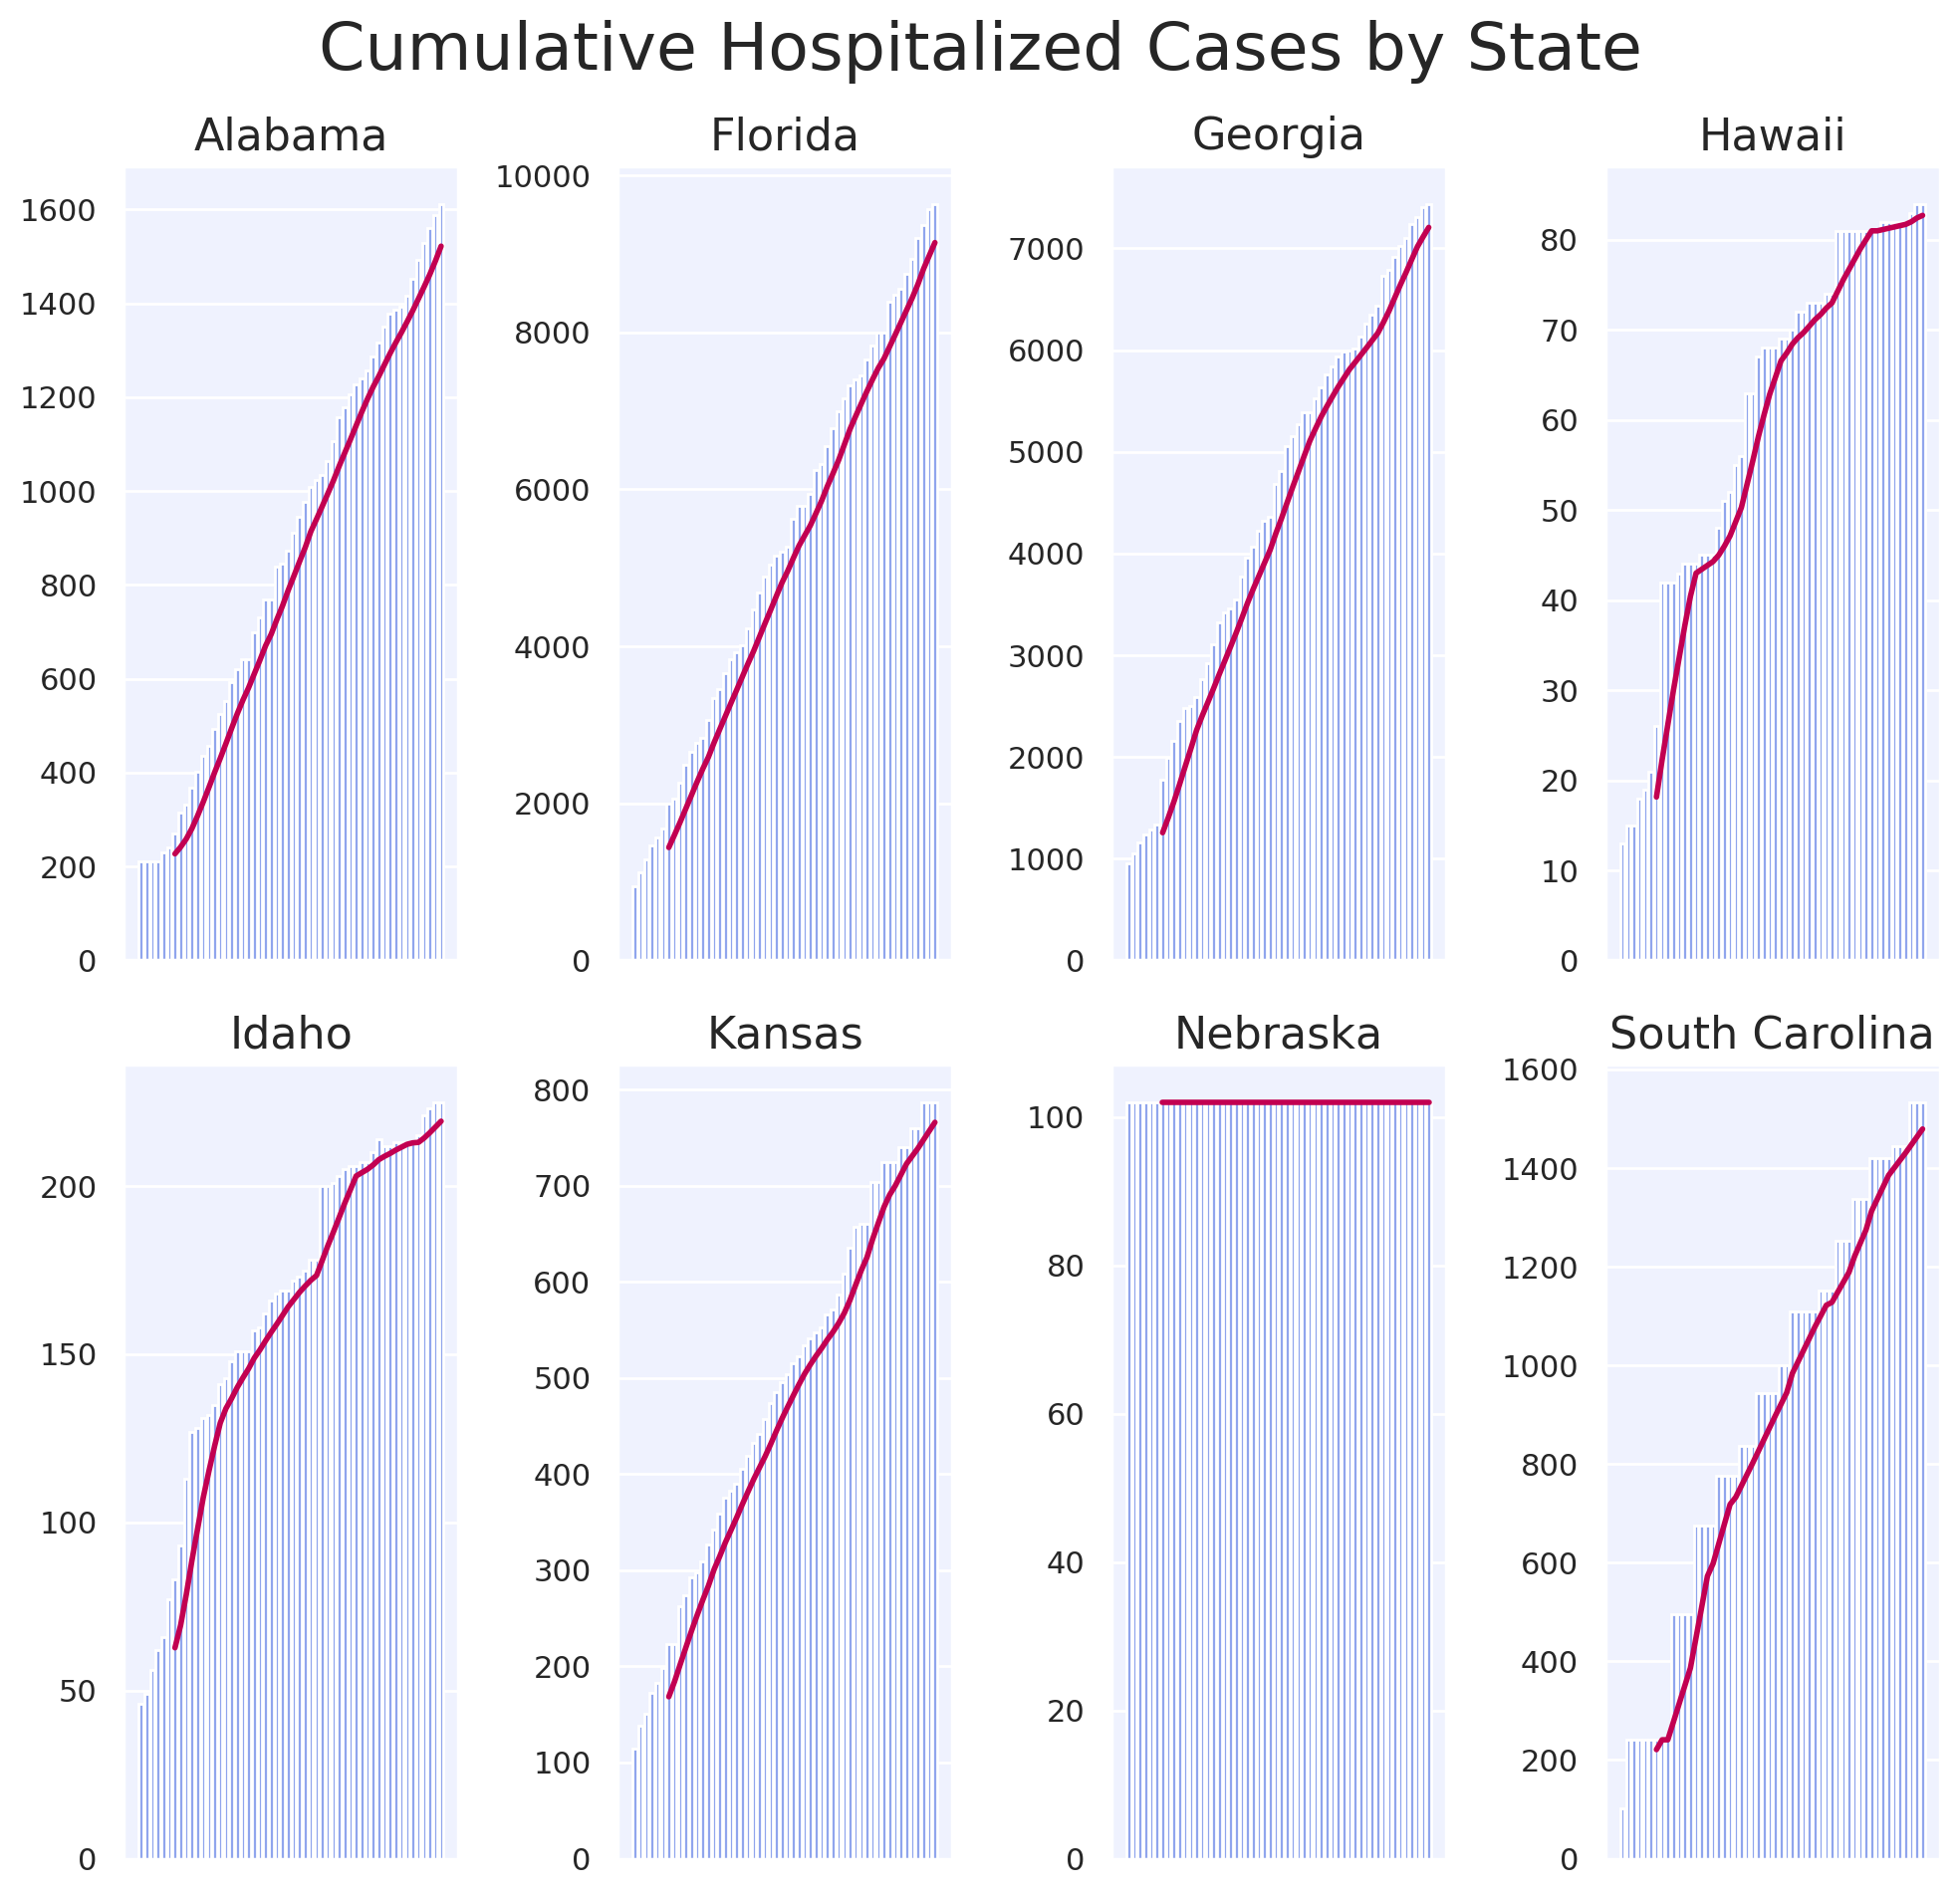

In [11]:
def counts_chart(df, states, dates):
    '''Plot distribution of case counts and the rolling average'''

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,10), dpi=200)
    fig.suptitle('Cumulative Hospitalized Cases by State', fontsize=24)

    for index, ax in enumerate(axes.flatten()):

        # Isolate state
        state = states[index]
        state_name = state_conversion[state]
        state_df = df[df['state'] == state]

        # Plot parameters
        ax.set_facecolor('#EFF2FE')
        ax.tick_params(labelbottom=False)
        ax.xaxis.grid(False)
        ax.set_title(state_name, fontsize=16)

        # Plot: Distribution of counts per day
        ax.bar(dates, state_df['hospitalizedCumulative'], color='#90A5ED', alpha=1.0, width=0.8)

        # Plot: Rolling Average
        ax.plot(dates, state_df['rolling_mean'], c='#C20051', alpha=1.0, linewidth=2.0)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('../images/hospitalized_cases-cumulative.png')
    plt.show()
    
counts_chart(temp, states, dates)

In [31]:
alabama = 551 / 1612   # deaths / total hospitalizations
florida = 2237 / 9638  
georgia = 1826 / 7439
hawaii = 17 / 84
idaho = 79 / 225
kansas = 207 / 787
nebraska = 150 / 102
sc = 435 / 1534
tn = 336 / 1583